# § 1 Introduction

### Key points from the paper

> ...a general-purpose agent which we call Gato, instantiated as a single, large, transformer sequence model.

> We focus our training at the operating point of model scale that allows real-time control of real-world robots, currently around 1.2B parameters in the case of Gato.

> To enable processing this multi-modal data, we serialize all data into a flat sequence of tokens.

My personal summary:

This is just a plain old transformer. Nothing new about the architecture.

The new stuff (and the most finicky to get right) is in tokenizing, sequencing, and assigning loss values to the different modalities.

We're going to try to make that new stuff as clear and simple as possible.

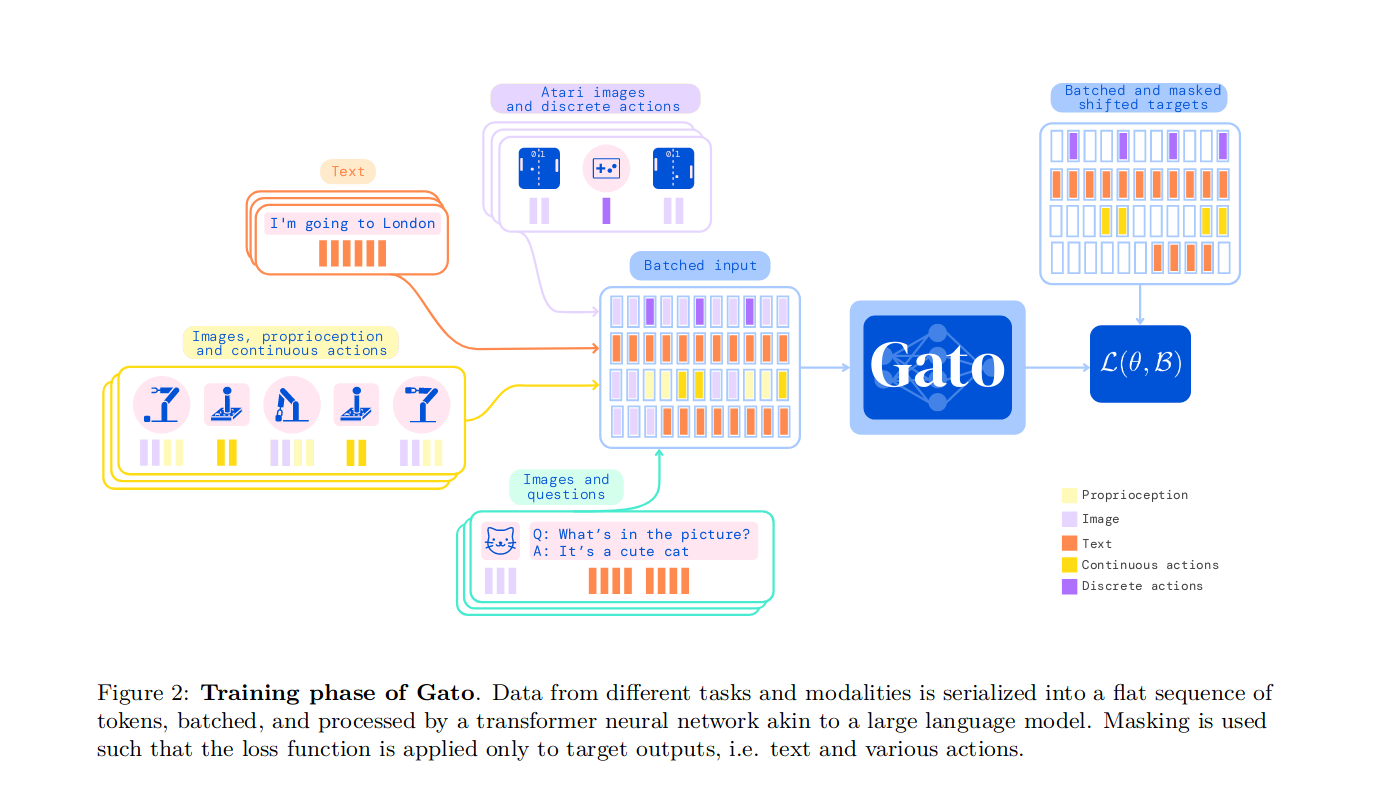

# § 2.1 Tokenization

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream. Below we report the tokenization scheme we found to produce the best results for Gato at the current scale using contemporary hardware and model architectures.

This is the best scheme they found. It would be interesting to see if recent advancements open up any new options.

> Text is encoded via SentencePiece (Kudo & Richardson, 2018) with 32000 subwords into the integer range [0, 32000).

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

> Discrete values, e.g. Atari button presses, are flattened into sequences of integers in row-major order. The tokenized result is a sequence of integers within the range of [0, 1024).

> Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values in row-major order. The values are mu-law encoded to the range [−1, 1] if not already there (see Figure 14 for details), then discretized to 1024 uniform bins. The discrete integers are then shifted to the range of [32000, 33024).

Let's dive in.

Our plan of attack is going to be to grab some very small datasets. We want to be able to move fast while we explore. We want small datasets and small models. Once we have a proof of concept, scaling up the size of our data and models will be a relatively simple and isolated task. We don't expect it to require any significant changes to the prior work we'll have done.

## Datasets

Let's grab datasets from a few different locations so that we can explore the process of translating a variety of datasets to a unified interface.

First, an overview of PyTorch Datasets and DataLoaders.

### Dataset

A couple of things to remember:

1. We might be working with large datasets. We need to consider how much memory we'll be consuming.

> If your Dataset loads the data lazily in __getitem__ each worker in your DataLoader will load one complete batch into memory.
> 
> \- https://discuss.pytorch.org/t/how-to-use-dataset-larger-than-memory/37785/4

2. If random reads are expensive, we might need to work with an IterableDataset, which has a few of its own caveats.

> This type of datasets is particularly suitable for cases where random reads are expensive or even improbable, and where the batch size depends on the fetched data.
>
> For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.
>
> When using a IterableDataset with multi-process data loading. The same dataset object is replicated on each worker process, and thus the replicas must be configured differently to avoid duplicated data. See IterableDataset documentations for how to achieve this.
>
> \- https://pytorch.org/docs/stable/data.html#iterable-style-datasets

### DataLoader

> Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
> 
> The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.
> 
> See [torch.utils.data](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) documentation page for more details.
> 
> \- https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

## What do we want our DataLoader to provide?

What kind of work should we do in the DataLoader? What kind of work should be the responsibility of the model?

It would be nice if the model could just take elements from the DataLoader and send them straight through to `model.forward(...)`.

And it would be nice if `model.forward(...)` could treat everything it received exactly the same.

Per Figure 2 on the Gato paper:

> Figure 2: Training phase of Gato. ***Data from different tasks and modalities is serialized into a flat sequence of tokens, batched, and processed by a transformer*** neural network akin to a large language model. Masking is used such that the loss function is applied only to target outputs, i.e. text and various actions.

By that, I mean, it would be nice if `model.forward(...)` receives the embeddings themselves.

If `model.forward(...)` doesn't receive the embeddings, if it receives the pixels of an image and the tokens of text, etc... then our model is going to need to handle conditionally branching off and performing a bunch of different types of tasks.

If our Datasets handled the embedding work, then our model remains simple.

This _does_ make our Dataset code a little more complex. But each dataset can be worked on in isolation. I think that's a fair trade-off.

### Embeddings...

Let's proceed with the goal of getting our Datasets to provide "episodes". We'll deal with whatever challenges that entails as they appear.

## Text Dataset


There's a popular dataset of 40,000 lines of Shakespeare's plays.

It's good because it's small (in comparison to something like wikitext), and it will be pretty obvious if training succeeds, because Shakespeare's writing is quite identifiable. And it might be fun to hear a picture of a tennis court described in the words of Shakespeare.


In the [words of Karpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data):

> Become one with the data.

Take a look at the [raw data](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) so you know what we're working with.

> ANTONIO:
> We two, my lord,
> Will guard your person while you take your rest,
> And watch your safety.
> 
> ALONSO:
> Thank you. Wondrous heavy.
> 
> SEBASTIAN:
> What a strange drowsiness possesses them!
> 
> ANTONIO:
> It is the quality o' the climate.
> 
> SEBASTIAN:
> Why
> Doth it not then our eyelids sink? I find not
> Myself disposed to sleep.

Each character's lines are separated by an empty line.

We want our training data to have a long enough context to learn from entire conversations of multiple characters. So, we don't want our DataLoader to return samples of 1 character speaking. That would be too short.

I suggest we split on each character's lines and then take a number of character's lines in sequence until we have more than ~250 words. That ought to play nicely with a sequence length of 512. And if we want to play with smaller sequence lengths, we can always truncate. (And larger sequence lengths we'll just pad.)

In [1]:
import os
from pathlib import Path
import re
import tempfile
import requests

temp_dir = tempfile.gettempdir()
shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
if not os.path.exists(shakespeare_filepath):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
    data = f.read()

characters_lines = re.split(r"\n\s*\n", data.strip())

In [2]:
print(data[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [3]:
MIN_WORDS_PER_BATCH = 250
sample = [characters_lines[0]]
num_words_in_sample = len(characters_lines[0].split())
text_dataset = []
i = 1
while i < len(characters_lines[:100]):
    if num_words_in_sample > MIN_WORDS_PER_BATCH:
        text_dataset.append("\n\n".join(sample))
        num_words_in_sample -= len(sample[0].split())
        sample = sample[1:]
    sample += [characters_lines[i]]
    num_words_in_sample += len(characters_lines[i].split())
    i += 1

In [4]:
text_dataset[:2]

["First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger

That seems reasonable.

Now to tokenize it.

The Gato paper encodes text via SentencePiece.

We're going to deviate slightly from the paper here. We're going to use th GPT2Tokenizer from HuggingFace `transformers` library. It's convenient. We'll also be using the [GPT2Model](https://huggingface.co/docs/transformers/en/model_doc/gpt2) (eventually, when we get to that point), so it seems reasonable to just remain in that ecosystem for the tokenizer as well.

In [5]:
from transformers import GPT2TokenizerFast

In [6]:
# Prefixing with _ to signify global.
_text_tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
_text_tokenizer.pad_token = _text_tokenizer.eos_token

In [7]:
import torch

### Context length

All modalities must share the same context length. We'll have to decide what that is now, since we're starting on our first modality, text.

Text is easy, because the text we train on will usually have a lot more than 1024 tokens of context, and truncating won't affect the quality of the context.

But when we get to things like videos/images/robotics, it might be hard to fit a single "episode" into a small context. Each image of a video might take up ~256 tokens, leaving us room for only 3 images in a single training example (with the remaining 256 tokens taken up by other forms of observation, like proprioception input).

I'll arbitrarily pick 1024 as a context window for now.

In [8]:
CONTEXT_WINDOW = 1024

def tokenize_text(max_length, text):
    tokenized = _text_tokenizer(
        text, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    return {
        "input_ids": tokenized["input_ids"].squeeze(0),
        "attention_mask": tokenized["attention_mask"].squeeze(0),
    }

In [9]:
from torch.utils.data import DataLoader
from functools import partial

In [10]:
BATCH_SIZE=3

In [11]:
text_dataloader = map(partial(tokenize_text, CONTEXT_WINDOW), DataLoader(text_dataset, batch_size=BATCH_SIZE))
text_batch = next(iter(text_dataloader))

In [12]:
print(text_batch["input_ids"].shape)
print(text_batch["input_ids"][0][:10])
print(text_batch["attention_mask"][0][:10])
print(text_batch["input_ids"][0][-10:])
print(text_batch["attention_mask"][0][-10:])

torch.Size([3, 1024])
tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [13]:
EMBEDDING_DIM = 432  # 12 * 12 * 3 images

In [14]:
import torch.nn as nn

In [15]:
_text_embedding = nn.Embedding(_text_tokenizer.vocab_size, EMBEDDING_DIM)

In [16]:
from functools import reduce, partial

In [17]:
def identity(x): return x
def wrap(f1, f2):
    def f3(arg):
        return f1(f2(arg))
    return f3

def compose(*fns): return reduce(wrap, fns, identity)

In [18]:
def get_text_embedding(text_embedding):
    def embed_text(tokens):
        return text_embedding(tokens)
    return embed_text
embed_text = get_text_embedding(_text_embedding)

In [19]:
def sequence_text(batch):
    tokens = tokenize_text(CONTEXT_WINDOW+1, batch)
    ys = tokens["input_ids"].clone()[:, 1:]
    embedding = embed_text(tokens["input_ids"][:, :-1])
    return embedding, ys, tokens["attention_mask"][:, :-1]

In [20]:
text_dataloader = map(sequence_text, DataLoader(text_dataset, batch_size=BATCH_SIZE, shuffle=True))
text_xs, text_ys, text_mask = next(iter(text_dataloader))

In [21]:
text_xs.shape, text_ys.shape, text_mask.shape

(torch.Size([3, 1024, 432]), torch.Size([3, 1024]), torch.Size([3, 1024]))

Sweet. That all looks good. We've got our text tokens.

Let's move on to images.

## Image and Questions Dataset

I happen to know of a very small VQA dataset on HuggingFace that we can use for question and answering about images.

In [22]:
import datasets

In [23]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format(
    "torch"
)

Once again, in the [words of the greatKarpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data)...

> Become one with the data.

Let's explore

In [24]:
vqa_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 20
    })
})

In [25]:
vqa_dataset["train"]

Dataset({
    features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
    num_rows: 80
})

In [26]:
vqa_dataset["train"]["question"][:5]

['What is the hairstyle of the blond called?',
 'How old do you have to be in canada to do this?',
 'Can you guess the place where the man is playing?',
 'Which rail company is named after a town in new mexico?',
 'Is the boy swimming or doing another water activity?']

In [27]:
len(vqa_dataset["train"]["answers"][0]), vqa_dataset["train"]["answers"][0][:3]

(10,
 [{'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(1)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(2)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(3)}])

This is the kind of one-off work you'll encounter for each dataset.

This particular VQA dataset offers 10 possible answers for each question. I assume the idea is that some image questions are ambiguous.

Part of our work is deciding how we want to handle that.

In the grand scheme of this model, I don't think there's a reasonable decision we could make here that would result in a significant change to the model quality.

My plan is to just randomly select an answer and ignore the "answer_confidence" value.

In [28]:
import random
from torch.utils.data import default_collate

In [29]:
def micro_ok_vqa_collate_fn(batch):
    answers = [random.choice(el["answers"])["answer"] for el in batch]
    questions = [el["question"] for el in batch]
    images = [el["image"] for el in batch]
    return {
        "question": questions,
        "image": images,
        "answer": answers,
    }

In [30]:
vqa_dl = DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)
vqa_batch = next(iter(vqa_dl))

In [31]:
len(vqa_batch["image"]), vqa_batch["image"][0].shape

(3, torch.Size([479, 640, 3]))

So, we've got 80 training images. They don't appear to be in any particularly standardized size. And they seem to be in a (height, width, channel) rank.

That's the rank that `matplotlib.pyplot.imshow` expects. But I think most PyTorch image-related functions expect (channel, height, width). So we'll have to permute that.

We'll also need to make them all the same shape. We can use PyTorch [transforms](https://pytorch.org/vision/stable/transforms.html) for that.

In [32]:
import matplotlib.pyplot as plt

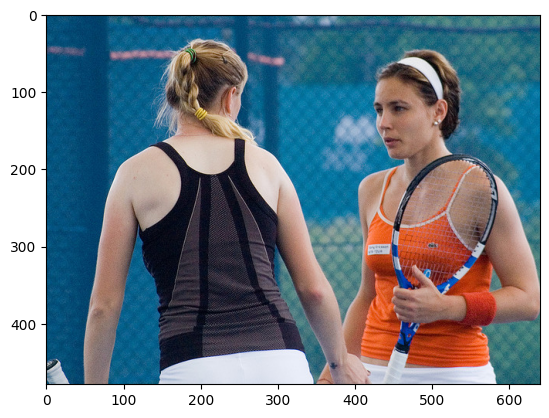

In [33]:
plt.imshow(vqa_batch["image"][0])

In [34]:
import torchvision.transforms.v2 as transforms

In [35]:
def _permute_channel_to_first(sample):
    sample["image"] = torch.permute(sample["image"], (2, 0, 1))
    return sample

micro_ok_vqa_transform = transforms.Compose([
    _permute_channel_to_first,    
    transforms.RandomResizedCrop((192, 192), (0.5, 1.0)),
])

In [36]:
def micro_ok_vqa_collate_fn(batch):
    answers = [random.choice(el["answers"])["answer"] for el in batch]
    questions = [el["question"] for el in batch]
    images = torch.stack([el["image"] for el in batch])  # Added torch.stack
    return {
        "question": questions,
        "image": images,
        "answer": answers,
    }

In [37]:
vqa_dl = DataLoader(
    vqa_dataset["train"]
    .map(micro_ok_vqa_transform),
    batch_size=8,
    collate_fn=micro_ok_vqa_collate_fn,
)
vqa_batch = next(iter(vqa_dl))

In [38]:
vqa_batch["image"].shape

torch.Size([8, 3, 192, 192])

Sweet.

Now.

How do we tokenize images?

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

We can't simply re-use the `tokenize_text` function that we used previously, because that function assumed the text was taking up the entire context window. The question/answer will only take up a small portion of the context window in the VQA case. The image will take up a large portion too.

In [39]:
images = vqa_batch["image"]

In [40]:
from einops import rearrange

In [41]:
patch_size=12

In [42]:
patches = rearrange(images, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

In [43]:
patches.shape

torch.Size([8, 256, 432])

In [44]:
reconstructed = rearrange(patches, 'b (ph pw) (sh sw c) -> b c (ph sh) (pw sw)', ph=16, pw=16, sh=patch_size, sw=patch_size)

In [45]:
reconstructed.shape

torch.Size([8, 3, 192, 192])

In [46]:
(reconstructed == images).all()

tensor(True)

In [47]:
def images_to_patches(images, patch_size=12):
    return rearrange(images, 'b c (h s1) (w s2) -> b (h w) (c s1 s2)', s1=patch_size, s2=patch_size)

In [48]:
def patches_to_image(patches, image_shape, patch_size=12):
    channels, height, width = image_shape
    patch_height = height // patch_size
    patch_width = width // patch_size
    reconstructed = rearrange(
        patches, 
        'b (ph pw) (c ps1 ps2) -> b c (ph ps1) (pw ps2)',
        ph=patch_height,
        pw=patch_width,
        ps1=patch_size,
        ps2=patch_size,
    )
    return reconstructed

In [49]:
# And to prove that we can go from image -> patch -> image
recovered_images = patches_to_image(images_to_patches(images), (3, 192, 192))
(recovered_images == images).all()

tensor(True)

In [50]:
12 * 12 * 3

432

In [51]:
from typing import Callable

> Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

How do we normalize?

How do we normalize along the _patch_ dimension?

In [52]:
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val = t.min()
    max_val = t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

In [53]:
normalize_to_between_minus_one_plus_one(torch.arange(6))

tensor([-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000])

In [54]:
def apply_along_dimension(
    func: Callable[[torch.Tensor], torch.Tensor], dim: int, tensor: torch.Tensor
):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

In [55]:
example = torch.arange(12).view(3, 2, 2)
print(f"starting tensor:\n{example}")
print(f"t * t.min() along dim 0:\n{apply_along_dimension(lambda t: t * t.min(), 0, example)}")
print(f"t * t.min() along dim 1:\n{apply_along_dimension(lambda t: t * t.min(), 1, example)}")
print(f"t * t.min() along dim 2:\n{apply_along_dimension(lambda t: t * t.min(), 2, example)}")

starting tensor:
tensor([[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11]]])
t * t.min() along dim 0:
tensor([[[ 0,  1],
         [ 4,  9]],

        [[ 0,  5],
         [12, 21]],

        [[ 0,  9],
         [20, 33]]])
t * t.min() along dim 1:
tensor([[[ 0,  1],
         [ 0,  3]],

        [[16, 25],
         [24, 35]],

        [[64, 81],
         [80, 99]]])
t * t.min() along dim 2:
tensor([[[  0,   0],
         [  4,   6]],

        [[ 16,  20],
         [ 36,  42]],

        [[ 64,  72],
         [100, 110]]])


In [56]:
def tokenize_image(image: torch.Tensor) -> torch.Tensor:
    """Convert images to patches, normalize each patch, then prepare it for
    embedding by reshaping to CxHxW so that we can send it through the conv
    layers of a ResNet block.
    """ 
    image = images_to_patches(image)
    # Hardcoding as a reminder to do something smarter
    SQUARE_ROOT_OF_PATCH_SIZE = 3.464
    image = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 2, image
        )
        / SQUARE_ROOT_OF_PATCH_SIZE
    )
    return image

In [57]:
vqa_batch["image_tokens"] = tokenize_image(vqa_batch["image"])

In [58]:
vqa_batch["image_tokens"].shape

torch.Size([8, 256, 432])

### Image Embedding

> 2.2 Embedding input tokens and setting output targets After tokenization and sequencing, we apply a parameterized embedding function f (·; θe) to each token (i.e. it is applied to both observations and actions) to produce the final model input. To enable efficient learning from our multi-modal input sequence s1:L the embedding function performs different operations depending on the modality the token stems from...

> Tokens belonging to image patches for any time-step are embedded using a single ResNet (He et al., 2016a) block to obtain a vector per patch. For image patch token embeddings, we also add a learnable within-image position encoding vector.

In [59]:
import torch.nn as nn

In [60]:
# From section 2.2 of the Gato paper:
#
#    Tokens belonging to image patches for any time-step are embedded using a
#    single ResNet (He et al., 2016a) block to obtain a vector per patch. For
#    image patch token embeddings, we also add a learnable within-image position
#    encoding vector.
class ResNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=24):
        super(ResNetV2Block, self).__init__()
        self.gn1 = nn.GroupNorm(1, in_channels)
        self.gelu = nn.GELU()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False
        )

    def forward(self, x):
        B, T, CHW = x.shape
        # TODO: Remove these hardcoded values.
        out = rearrange(x, 'b t (c h w) -> (b t) c h w', c=3, h=16)
        out = self.gn1(out)
        out = self.gelu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = self.gelu(out)
        out = self.conv2(out)
        return x + rearrange(out, '(b t) c h w -> b t (c h w)', b=B, t=T)

_image_embedding = ResNetV2Block(3, EMBEDDING_DIM)
_position_embedding = nn.Embedding(256, EMBEDDING_DIM)

In [61]:
torch.arange(CONTEXT_WINDOW), EMBEDDING_DIM

(tensor([   0,    1,    2,  ..., 1021, 1022, 1023]), 432)

In [62]:
torch.arange(CONTEXT_WINDOW), EMBEDDING_DIM

(tensor([   0,    1,    2,  ..., 1021, 1022, 1023]), 432)

In [63]:
_position_embedding(torch.arange(256)).shape

torch.Size([256, 432])

In [680]:
# TODO: This isn't how Gato does position embeddings.
# See Figure 17.
# I think their idea is that they want a separate row and column position embedding.
# Is that needed? My idea is that the embedding table would learn to distinguish that itself.
# Maybe their's generalizes better with less data?
def embed_image(image_tokens):
    return _image_embedding(image_tokens) + _position_embedding(torch.arange(256))

In [65]:
image_embeddings = embed_image(vqa_batch["image_tokens"])
image_embeddings.shape

torch.Size([8, 256, 432])

Transform, tokenize, embed, sequence.

In [66]:
_text_tokenizer.bos_token

'<|endoftext|>'

In [67]:
# Hardcoding max_length so that the entire sequence fills a 1024 context window.
def sequence_vqa(batch, bos_token="<|endoftext|>", eos_token="<|endoftext|>"):
    question = [bos_token + q + eos_token for q in batch["question"]]
    question_tokens = _text_tokenizer(
        question, 
        truncation=True, 
        padding="max_length", 
        max_length=513,
        return_tensors="pt"
    )
    if "answer" not in batch:
        answer = [bos_token for _ in question]
    else:
        answer = [bos_token + a + eos_token for a in batch["answer"]]
    answer_tokens = _text_tokenizer(
        answer, 
        truncation=True, 
        padding="max_length", 
        max_length=257, 
        return_tensors="pt"
    )
    
    image_tokens = tokenize_image(batch["image"])
    image_attention_mask = torch.zeros_like(image_tokens)

    question_embedding = embed_text(question_tokens["input_ids"][:, :-1])
    answer_embedding = embed_text(answer_tokens["input_ids"][:, :-1])
    image_embedding = embed_image(image_tokens)
    xs = torch.concat([question_embedding, image_embedding, answer_embedding], dim=1)
    ys = torch.concat([question_tokens["input_ids"][:, 1:], torch.zeros(image_tokens.shape[:2]), answer_tokens["input_ids"][:, 1:]], dim=1).int()
    attention_mask = torch.concat([question_tokens["attention_mask"][:, :-1], torch.zeros(image_tokens.shape[:2]), answer_tokens["attention_mask"][:, :-1]], dim=1)
    return xs, ys, attention_mask

In [68]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("torch")
vqa_dataloader = map(sequence_vqa, DataLoader(vqa_dataset["train"].map(micro_ok_vqa_transform), batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn))
xs, ys, mask = next(vqa_dataloader)

In [69]:
xs.shape, ys.shape, mask.shape, ys.dtype

(torch.Size([3, 1024, 432]),
 torch.Size([3, 1024]),
 torch.Size([3, 1024]),
 torch.int32)

In [70]:
import torch.nn.functional as F

In [71]:
## Loss
##
## See section 2.3 of the Gato paper.
##
##   Let b index a training batch of sequences B. We define a masking function m
##   such that m(b, l) = 1 if the token at index l is either from text or from
##   the logged action of an agent, and 0 otherwise. The training loss for a
##   batch B can then be written as...
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / mask.sum()
    return loss

In [72]:
from transformers import GPT2TokenizerFast, GPT2Config, GPT2Model

In [73]:
device = torch.device('cuda')

In [74]:
def init_model():
    configuration = GPT2Config(
        n_layer=2,
        n_head=2,
        n_embd=EMBEDDING_DIM
    )
    model = GPT2Model(configuration)
    return model


def init_optimizer(params):
    optimizer = torch.optim.AdamW(params)
    return optimizer

In [75]:
model = init_model().to(device)

In [76]:
HIDDEN_DIMS=EMBEDDING_DIM
lm_head = nn.Linear(model.config.hidden_size, _text_tokenizer.vocab_size).to(device)
params = (
    list(model.parameters())
    + list(_text_embedding.parameters())
    + list(_image_embedding.parameters())
    + list(_position_embedding.parameters())
    + list(lm_head.parameters())
)
optimizer = init_optimizer(params)
text_dataloader = map(sequence_text, DataLoader(text_dataset, batch_size=BATCH_SIZE))
vqa_dataloader = map(sequence_vqa, DataLoader(vqa_dataset["train"].map(micro_ok_vqa_transform), batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn))
text_dataloader_iter = iter(text_dataloader)
vqa_dataloader_iter = iter(vqa_dataloader)

In [79]:
print(f"Number of parameters: {sum(p.numel() for p in params):.2e}")

Number of parameters: 7.03e+07


In [80]:
from tqdm.notebook import tqdm

In [81]:
i = 100
bos_token = eos_token = _text_tokenizer.bos_token
model.train()
for epoch in tqdm(range(i)):
    try:
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    except StopIteration:
        text_dataloader_iter = iter(map(sequence_text, DataLoader(text_dataset, batch_size=BATCH_SIZE)))
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    try:
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    except StopIteration:
        vqa_dataloader_iter = iter(map(sequence_vqa, DataLoader(vqa_dataset["train"].map(micro_ok_vqa_transform), batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    x = torch.concat([text_xs, vqa_xs]).to(device)
    y = torch.concat([text_ys, vqa_ys]).to(device)
    m = torch.concat([text_mask, vqa_mask]).to(device)
    # x = vqa_xs.to(device)
    # y = vqa_ys.to(device).to(torch.long)
    # m = vqa_mask.to(device)    
    optimizer.zero_grad()
    o = model(inputs_embeds=x)
    p = lm_head(o.last_hidden_state)
    loss = cross_entropy(p, y, m)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")        

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100], Loss: 11.025444030761719
Epoch [50/100], Loss: 4.387798309326172


In [82]:
model.eval()
with torch.no_grad():
    text = "First Citizen:"
    for _ in range(20):
        tokens = tokenize_text(CONTEXT_WINDOW, [text])
        x = embed_text(tokens["input_ids"].unsqueeze(0)).to(device)
        m = tokens["attention_mask"].unsqueeze(0).to(device)
        length = m.sum().item()
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
        text += _text_tokenizer.decode(chosen[0])

In [84]:
print(text)

First Citizen: who aims, that was made he hath faults, if they
IUS:

 peaceutch


In [91]:
sample = next(iter(DataLoader(vqa_dataset["train"].map(micro_ok_vqa_transform), batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))

In [103]:
question = [sample["question"][0]]
image = [sample["image"][0]]

In [132]:
model.eval()
batch = {
    "question": question,
    "image": image,
    "answer": [""],
}
with torch.no_grad():
    i = 0
    token = ""
    while i < 10 and token != eos_token:
        x, y, m = sequence_vqa(batch)
        x, y, m = x.to(device), y.to(device), m.to(device)
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        token = _text_tokenizer.decode(predicted.softmax(dim=2)[0].multinomial(num_samples=1).squeeze(1)[768+i])
        # token = _text_tokenizer.decode(predicted.argmax(dim=2).squeeze(0)[768+i])
        batch["answer"][0] += token
        i += 1
batch["answer"]

['FalseThough<|endoftext|>']

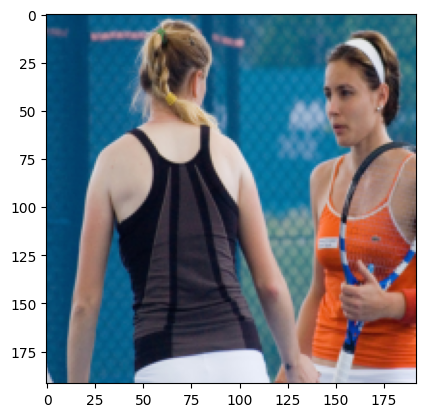

In [133]:
plt.imshow(sample["image"][0].permute(1, 2, 0))

# Robotics

Robotics is extra challenging because there's multiple things you might need to pad in a batch.

Each sample in a batch might be of a different sequence length.

Then, inside the sequence, each timestep might have a different observation length. 

You need to do this thing where you pad to the longest along each dimension and return attention masks along the sequence. And each dimension might require its own special padding token.

In [136]:
import minari

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Position

https://youtu.be/kCc8FmEb1nY?t=3619

From the paper:

> Timesteps in turn are presented in the following order:
>
> – Observations ([y1:k, x1:m, z1:n]) are ordered lexicographically by key, each item is sequenced as follows:
>
>  ∗ Text tokens (y1:k) are in the same order as the raw input text.
>
> ∗ Image patch tokens (x1:m) are in raster order.
>
> ∗ Tensors (z1:n) (such as discrete and continuous observations) are in row-major order.

In [137]:
minigrid_fourrooms_dataset = minari.load_dataset('minigrid-fourrooms-v0', download=True)

The Minari datasets return an EpisodeData object, so we need a custom collate function.

In [377]:
minigrid_fourrooms_dataset[0].observations.keys()

dict_keys(['direction', 'image', 'mission'])

In [378]:
from torch.utils.data import default_collate

In [550]:
obs0 = minigrid_fourrooms_dataset[0].observations
obs0 = torch.as_tensor(obs0["direction"])

In [551]:
obs1 = minigrid_fourrooms_dataset[1].observations
obs1 = torch.as_tensor(obs1["direction"])

In [552]:
obs2 = minigrid_fourrooms_dataset[2].observations
obs2 = torch.as_tensor(obs2["direction"])

In [556]:
def padmask(t, n, dim=-1, value=0):
    """Return (padded tensor, padding mask)."""
    if dim == -1:
        dim = len(t.shape)-1
    pad = []
    for i in range(len(t.shape)-1):
        pad.append(0)
        pad.append(0)
    pad.append(0)
    pad.append(n)
    for i in range(len(pad), len(t.shape)):
        pad.append(0)
        pad.append(0)
    mask = torch.concat([torch.ones(t.size(dim)), torch.zeros(n)]).to(t.dtype)
    return F.pad(t, pad, value=value), mask

In [557]:
padmask(obs1, 3)

(tensor([3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]))

In [558]:
def padlong(ts, dim=-1, value=0):
    if not ts:
        return
    if dim == -1:
        dim = len(ts[0].shape)-1
    longest = max(t.size(dim) for t in ts)
    ts, masks = zip(*[padmask(t, longest-t.size(dim), dim=dim) for t in ts])
    return torch.stack(ts, dim=0), torch.stack(masks, dim=0)

In [559]:
obs2.shape

torch.Size([29])

In [560]:
padlong([obs0, obs1, obs2], dim=0)

(tensor([[0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
          1, 1, 1, 1, 1]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1]]))

In [561]:
obs0 = minigrid_fourrooms_dataset[0].observations
obs0 = torch.as_tensor(obs0["image"])

In [562]:
obs1 = minigrid_fourrooms_dataset[7].observations
obs1 = torch.as_tensor(obs1["image"])

In [563]:
obs2 = minigrid_fourrooms_dataset[8].observations
obs2 = torch.as_tensor(obs2["image"])

In [564]:
obs2.shape, obs1.shape, obs0.shape

(torch.Size([11, 7, 7, 3]),
 torch.Size([34, 7, 7, 3]),
 torch.Size([20, 7, 7, 3]))

In [568]:
images, images_masks = padlong([obs0, obs1, obs2], dim=0)
images.shape
images.shape, images_masks.shape

(torch.Size([3, 34, 7, 7, 3]), torch.Size([3, 34]))

In [634]:
def minari_minigrid_collate_fn(batch):
    directions, directions_mask = padlong([torch.as_tensor(x.observations["direction"]) for x in batch])
    actions, actions_mask = padlong([torch.as_tensor(x.actions) for x in batch])
    terminations, terminations_mask = padlong([torch.as_tensor(x.terminations) for x in batch])
    truncations, truncations_mask = padlong([torch.as_tensor(x.truncations) for x in batch])
    images, images_mask = padlong([torch.as_tensor(x.observations["image"]) for x in batch], dim=0)
    return {
        "observations": {
            "direction": directions,
            "direction_mask": directions_mask,
            "image": images,
            "image_mask": images_mask,
            "mission": [x.observations["mission"] for x in batch],
        },
        "actions": actions,
        "actions_mask": actions_mask,
        "terminations": terminations.to(torch.int),
        "terminations_mask": terminations_mask.to(torch.int),
        "truncations": truncations.to(torch.int),
        "truncations_mask": truncations_mask.to(torch.int),
    }

In [635]:
minigrid_batch = next(iter(DataLoader(minigrid_fourrooms_dataset, collate_fn=minari_minigrid_collate_fn, batch_size=8)))

In [636]:
minigrid_batch["observations"]["direction"].shape, minigrid_batch["actions"].shape, minigrid_batch["observations"]["image"].shape

(torch.Size([8, 34]), torch.Size([8, 33]), torch.Size([8, 34, 7, 7, 3]))

In [637]:
images = minigrid_batch["observations"]["image"]
images = [torch.as_tensor(i) for i in images]
images = padlong(images, dim=0)
[x.shape for x in minigrid_batch["observations"]["image"]], [x for x in minigrid_batch["observations"]["image_mask"]][0]

([torch.Size([34, 7, 7, 3]),
  torch.Size([34, 7, 7, 3]),
  torch.Size([34, 7, 7, 3]),
  torch.Size([34, 7, 7, 3]),
  torch.Size([34, 7, 7, 3]),
  torch.Size([34, 7, 7, 3]),
  torch.Size([34, 7, 7, 3]),
  torch.Size([34, 7, 7, 3])],
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8))

In [ ]:
mission_tokenized = [
    _text_tokenizer(
        m,
        truncation=True, 
        padding="longest",
        return_tensors="pt"
    )
    for m in minigrid_batch["observations"]["mission"]
]
len(mission_tokenized), mission_tokenized[0]["input_ids"].shape, mission_tokenized[7]["input_ids"].shape

Samples in a batch.
Observations in a sample.
Mission in an observation.

Each sample might have a different number of observations.
This can be thought of as the sequence length.

Each observation might have a different mission.

A single batch element is going to be:

A sequence of episodes.

Each episode is going to be:

A sequence of timesteps.

Each timestep is going to be:

A sequence of observations.

Each observation is going to be:

A sequence of [text, image, sensor data, separator, actions].

In [ ]:
tokenizers = {
    ''
}

In [662]:
minigrid_fourrooms_dataset[0].observations.keys(), minigrid_fourrooms_dataset[0].observations["mission"][0]

(dict_keys(['direction', 'image', 'mission']), 'reach the goal')

In [677]:
def sequence_minigrid_fourrooms_timestep(timestep):
    # In alphabetical order by key, "direction", "image", "mission"
    mission = _text_tokenizer.encode(_text_tokenizer.bos_token + timestep["mission"] + _text_tokenizer.eos_token)
    
    return mission

In [668]:
minigrid_fourrooms_dataset[0]

EpisodeData(id=0, seed=1608637542, total_timesteps=19, observations={direction: ndarray of shape (20,) and dtype int64, image: ndarray of shape (20, 7, 7, 3) and dtype uint8, mission: ['reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal']}, actions=ndarray of shape (19,) and dtype int64, rewards=ndarray of 19 floats, terminations=ndarray of 19 bools, truncations=ndarray of 19 bools, infos=dict with the following keys: [])

In [678]:
episode = minigrid_fourrooms_dataset[0]
timesteps = [{
    "direction": episode.observations["direction"][i],
    "image": episode.observations["image"][i],
    "mission": episode.observations["mission"][i],
    "action": episode.actions[i],
} for i in range(episode.total_timesteps)]
sequence_minigrid_fourrooms_timestep(timesteps[0])

[50256, 16250, 262, 3061, 50256]

In [638]:
def tokenize_fourrooms(batch):
    mission_tokenized = [
        _text_tokenizer(
            m,
            truncation=True, 
            padding="longest",
            return_tensors="pt"
        )
        for m in batch["observations"]["mission"]
    ]
    mission_input_ids, mission_attention_mask = padlong([m["input_ids"] for m in mission_tokenized], dim=0)
    attention_masks = padlong([m["attention_mask"] for m in mission_tokenized], dim=0)
    
    return {
        "input_ids": input_ids,
        "attention_masks": attention_masks,
    }

In [644]:
tokenize_fourrooms(minigrid_batch)["input_ids"]

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
def sequence_fourrooms(batch):
    tokenized = tokenize_fourrooms(batch)
    

### Robotic text tokens

The mission. Easy.

In [ ]:
episode_text_tokens = text_tokenizer(episode_data.observations["mission"])
episode_text_tokens

### Robotic image tokens

Minigrid observations are small, 7x7x3. We already have an image tokenizer that works with 256x256x3 images. Let's just resize these to be 256x256x3 and use the same tokenizer. We could probably cram more episodes into a context window if we did something clever with small images. But we're aiming for simplicity.

In [ ]:
episode_data.observations["image"][0]

In [ ]:
def fourrooms_image_transform(img):
    resize = transforms.Resize((256, 256))
    img = torch.tensor(episode_data.observations["image"])
    img = img.permute(2, 0, 1)
    img = resize(img)
    img = img.permute(1, 2, 0)
    img = img / img.max()
    return img

In [ ]:
minigrid_fourrooms_dataset[0]

In [ ]:
print(minigrid_fourrooms_dataset[0].observations["direction"])
print(minigrid_fourrooms_dataset[0].actions)

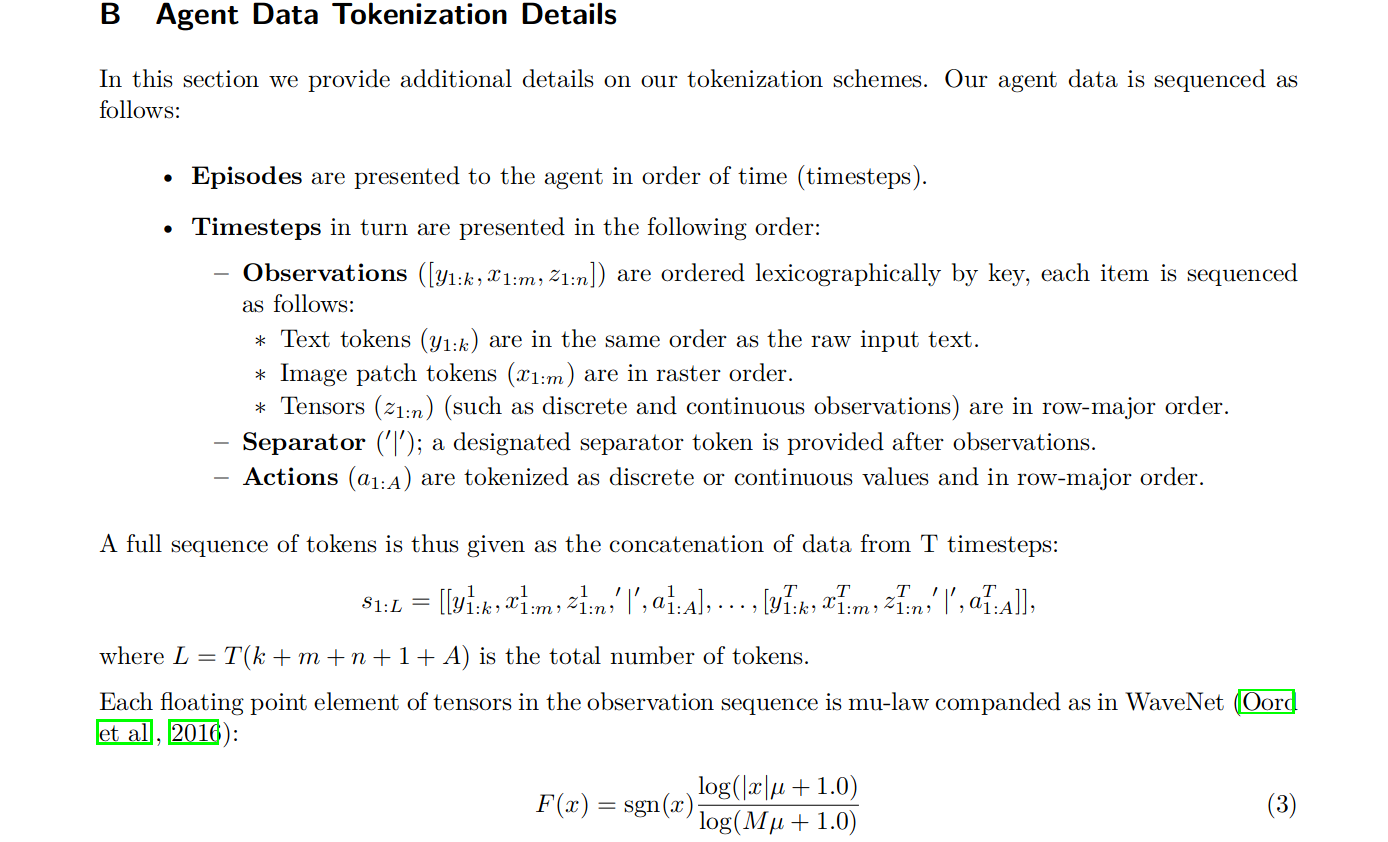

In [ ]:
def minari_minigrid_collate_fn(batch):
    return {
        "id": torch.Tensor([x.id for x in batch]),
        "seed": torch.Tensor([x.seed for x in batch]),
        "total_timesteps": torch.Tensor([x.total_timesteps for x in batch]),
        "observations": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.observations) for x in batch],
            batch_first=True
        ),
        "actions": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.actions) for x in batch],
            batch_first=True
        ),
        "rewards": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.rewards) for x in batch],
            batch_first=True
        ),
        "terminations": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.terminations) for x in batch],
            batch_first=True
        ),
        "truncations": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.truncations) for x in batch],
            batch_first=True
        )
    }

In [ ]:
dataloader = DataLoader(minigrid_fourrooms_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=minari_minigrid_collate_fn)

In [ ]:
minigrid_fourrooms_dataset[1].rewards

In [ ]:
minigrid_sample = next(iter(dataloader))

## Robotics Dataset

Another one that's relatively small and easy to grab from HuggingFace.

[cartpole](https://huggingface.co/datasets/ml-frameworks/cartpole)

> Description
> 
> The dataset consists of 1,000 episodes with an average episodic reward of 500. Each entry consists of:
> 
> obs (list): observation with length 4.
> action (int): action (0 or 1).
> reward (float): reward point for that timestep.
> episode_returns (bool): if that state was the initial timestep for an episode.

In [ ]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

In [ ]:
def animate(frame):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    img.set_data(env.render())
    if terminated or truncated:
        env.reset()
    return (img,)

In [ ]:
observation, info = env.reset()
fig = plt.figure(figsize=(8, 6))
img = plt.imshow(env.render())
plt.axis('off')

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, blit=True)
display.display(display.HTML(anim.to_jshtml()))

In [ ]:
step = env.step(action)

In [ ]:
observation, reward, terminated, truncated, info = env.step(action)

In [ ]:
observation.keys()

In [ ]:
cartpole_dataset = datasets.load_dataset("ml-frameworks/cartpole").with_format("torch")

In [ ]:
cartpole_dataset

In [ ]:
cartpole_dataset["train"]["observation"].shape

In [ ]:
cartpole_dataset["train"]["observation"][0], cartpole_dataset["train"]["next_observation"][0]

How does Gato handle continous values like this?

> Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values in row-major order. The values are mu-law encoded to the range [−1, 1] if not already there (see Figure 14 for details), then discretized to 1024 uniform bins. The discrete integers are then shifted to the range of [32000, 33024).

In [ ]:
cartpole_dataset["train"]["observation"][1]

http://minari.farama.org/datasets/minigrid/fourrooms-random/

In [ ]:
import pdb; pdb.pm()